<a href="https://colab.research.google.com/github/Zahra-Nahardani/brain-tumor-classification/blob/main/Brain-Tumor-MRI-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The project aims to develop a machine-learning-based classification system for detecting and categorizing brain tumors from medical images using deep learning techniques.

# The core objective is to classify brain tumors into four categories: Glioma, Meningioma, Pituitary Tumor, and No Tumor using Convolutional Neural Networks (CNNs) and transfer learning with EfficientNetB0 fine-tuned on the MRI domain.

# **Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================
# Import Libraries
# ============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.preprocessing import image


import warnings
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# **Data Processing**

In [ ]:
!cp -r "/content/drive/My Drive/ML/Data2" /tmp/Data2

In [ ]:
# ============================
#  Read Dataset
# ============================

drive_path = "/tmp/Data2"
train_data_dir = os.path.join(drive_path, "Training")
test_data_dir = os.path.join(drive_path, "Testing")

def load_data(data_dir):
    "Load image file paths and labels into a DataFrame."
    filepaths, labels = [], []
    for fold in os.listdir(data_dir):
        foldpath = os.path.join(data_dir, fold)
        for file in os.listdir(foldpath):
            filepaths.append(os.path.join(foldpath, file))
            labels.append(fold)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})



---


* The dataset comprises a total of 7023 human brain MRI images, categorized into four distinct classes.

In [ ]:
# ============================
#  Train and Test Data
# ============================

# Load training and testing data
train_df = load_data(train_data_dir)
test_df = load_data(test_data_dir)

In [ ]:
print(f'Training length:' ,len(train_df))
print(f'Testing length:' ,len(test_df))

Training length: 5712
Testing length: 1311


In [ ]:
# Split test set into validation and test sets (50% each)
valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)



---


* The pie chart represents the distribution of training data across four different categories.

* The dataset appears relatively balanced, but notumor is slightly overrepresented.

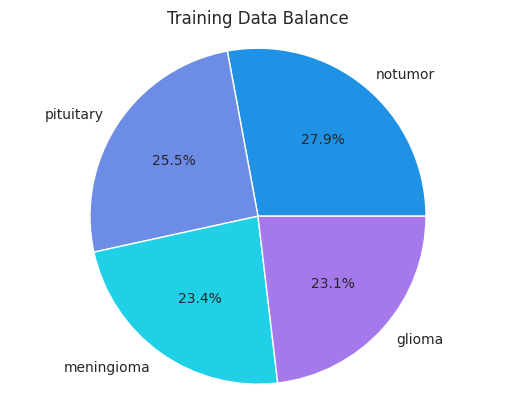

In [ ]:
# ============================
# Visualize Data Distribution
# ============================

data_balance = train_df.labels.value_counts()

plt.pie(data_balance, labels=data_balance.index, autopct='%1.1f%%', colors=["#2092E6","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training Data Balance")
plt.axis("equal")
plt.show()

In [ ]:
# ============================
# Data Generator Setup
# ============================

batch_size = 16
img_size = (224, 224)

# Generatore to apply transforms
tr_gen = ImageDataGenerator(
  rescale=1./255,
  brightness_range=(0.8, 1.2),
 )
ts_gen = ImageDataGenerator(
  rescale=1./255,
)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
x_batch, y_batch = next(train_gen)
print(x_batch.shape, y_batch.shape)  # (batch_size, height, width, channels) (batch_size, num_classes)

(16, 224, 224, 3) (16, 4)


In [ ]:
train_gen.image_shape

(224, 224, 3)




---


*   A single training batch of 16 preprocessed MRI images (224×224), each annotated with its true class label.


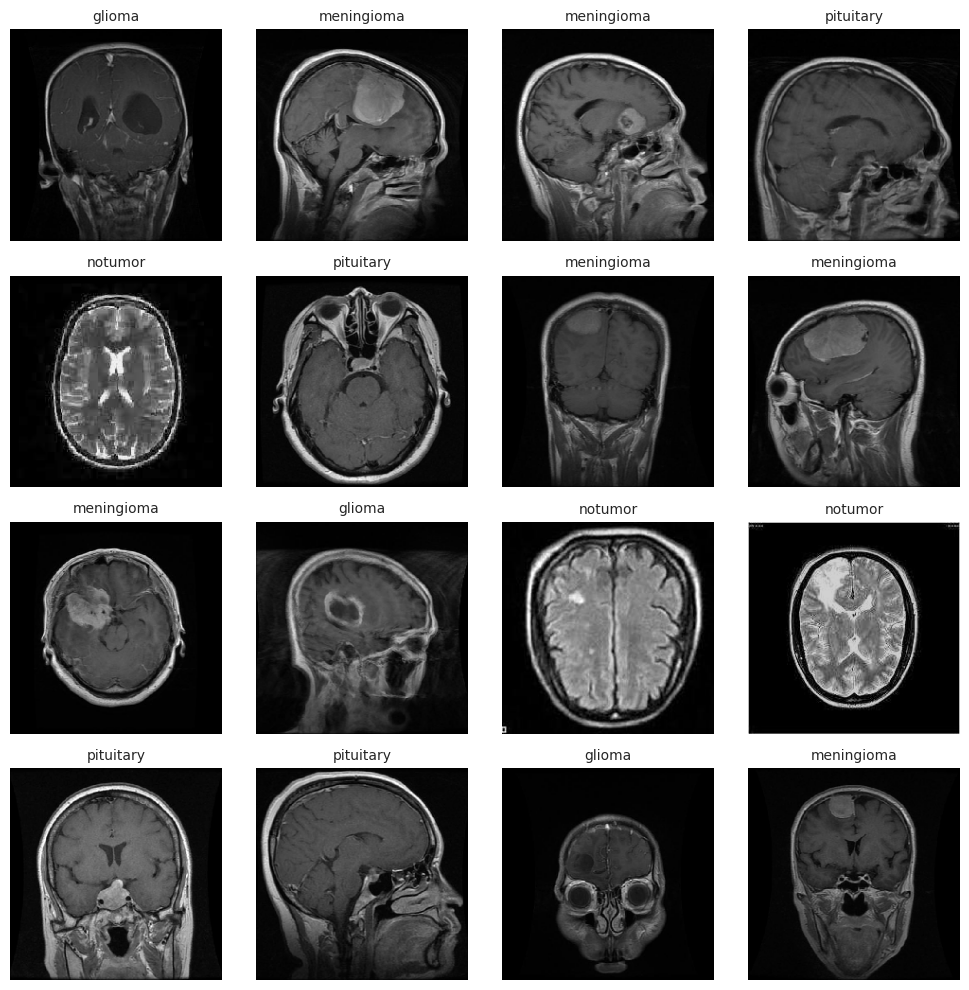

In [ ]:
# ============================
# Visualize Sample Images
# ============================

g_dict = train_gen.class_indices  # {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **CNN Model Architecture**

In [ ]:
# Input layer
img_shape = (224, 224, 3)

class_count = len(train_gen.class_indices.keys())

cnn_model = Sequential([
    # Conv block
    Conv2D(32, (3,3), padding="same", activation="relu", input_shape=img_shape),
    MaxPooling2D(),

    Conv2D(64, (3,3), padding="same", activation="relu"),
    MaxPooling2D(),

    Flatten(),

    # fully_connected dense layer
    Dense(128, activation="relu"),
    Dropout(0.5),

    # output layer
    Dense(class_count, activation="softmax")
])

In [ ]:
cnn_model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,710,148 (98.08 MB)

 Trainable params: 25,710,148 (98.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ============================
# Train the CNN Model
# ============================

epochs = 10
trained_cnn_model = cnn_model.fit(train_gen, epochs=epochs, validation_data=valid_gen, shuffle=False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 638s 2s/step - accuracy: 0.6670 - loss: 0.8655 - val_accuracy: 0.8550 - val_loss: 0.3442
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 677s 2s/step - accuracy: 0.8854 - loss: 0.3106 - val_accuracy: 0.8977 - val_loss: 0.2226
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - accuracy: 0.9375 - loss: 0.1928 - val_accuracy: 0.9466 - val_loss: 0.1391
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.9575 - loss: 0.1157 - val_accuracy: 0.9511 - val_loss: 0.1327
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 630s 2s/step - accuracy: 0.9732 - loss: 0.0854 - val_accuracy: 0.9649 - val_loss: 0.1032
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.9822 - loss: 0.0531 - val_accuracy: 0.9557 - val_loss: 0.1164
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.9799 - loss: 0.0550 - val_accuracy: 0.9618 - val_loss: 0.1203
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 631s 2s/step - accuracy: 0.9876 - loss: 0.0402 - val_accu



---


Model Performance:



In [ ]:
# ============================
# Evaluate the Model
# ============================

train_score = cnn_model.evaluate(train_gen)
valid_score = cnn_model.evaluate(valid_gen)
test_score = cnn_model.evaluate(test_gen)

print(f"\n Train Accuracy: {train_score[1]:.4f}")
print(f" Validation Accuracy: {valid_score[1]:.4f}")
print(f" Test Accuracy: {test_score[1]:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 167s 467ms/step - accuracy: 0.9984 - loss: 0.0067
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 439ms/step - accuracy: 0.9684 - loss: 0.1056
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 444ms/step - accuracy: 0.9518 - loss: 0.1821

 Train Accuracy: 0.9979
 Validation Accuracy: 0.9664
 Test Accuracy: 0.9543




---

This is the confusion matrix for the CNN on the test set. For example in the first row:


*   129 correctly predicted as glioma

*   22 mis‐predicted as meningioma




41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 468ms/step


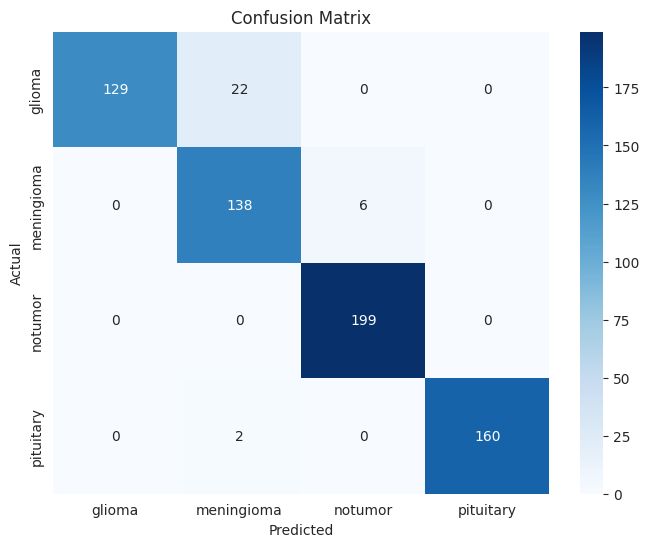

In [ ]:
# ============================
# Confusion Matrix
# ============================

preds = cnn_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



---

* The accuracy shows 95 % of the 656 test images were classified correctly.

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

      glioma       1.00      0.85      0.92       151
  meningioma       0.85      0.96      0.90       144
     notumor       0.97      1.00      0.99       199
   pituitary       1.00      0.99      0.99       162

    accuracy                           0.95       656
   macro avg       0.96      0.95      0.95       656
weighted avg       0.96      0.95      0.95       656



## Save - Load

In [ ]:
# ============================
# save trained cnn model
# ============================

model_path = '/content/drive/My Drive/ML/Brain_CNN_Model.h5'
cnn_model.save(model_path)
print(f"Model saved successfully at: {model_path}")

Model saved successfully at: /content/drive/My Drive/ML/Brain_CNN_Model.h5


In [ ]:
# ============================
# load trained cnn model
# ============================

model_path = '/content/drive/My Drive/ML/Brain_CNN_Model.h5'
cnn_model = load_model(model_path)
print("CNN Model loaded successfully!")

In [ ]:
cnn_history = trained_cnn_model.history
import pickle
with open('/content/drive/My Drive/ML/cnn_history.pkl', 'wb') as f:
    pickle.dump(cnn_history, f)

In [ ]:
import pickle
with open('/content/drive/My Drive/ML/cnn_history.pkl', 'rb') as f:
    cnn_history = pickle.load(f)

tr_acc_cnn  = cnn_history['accuracy']
val_acc_cnn = cnn_history['val_accuracy']

# **Fine-Tuning a Pre-trained EfficientNetB0**

In [ ]:
effnet_img_size = (224, 224)

tr_gen_eff = ImageDataGenerator(
    preprocessing_function=effnet_preprocess,   # prepare images for the model
    brightness_range=(0.8, 1.2),
)
ts_gen_eff = ImageDataGenerator(
    preprocessing_function=effnet_preprocess,
)

train_gen_eff = tr_gen_eff.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels',
    target_size=(224, 224), class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=batch_size
 )
valid_gen_eff = ts_gen_eff.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels',
    target_size=(224, 224), class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=batch_size
)
test_gen_eff = ts_gen_eff.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels',
    target_size=(224, 224), class_mode='categorical',
    color_mode='rgb', shuffle=False, batch_size=batch_size
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
#Creates an EfficientNetB0 feature extractor

effnet_base_model = EfficientNetB0(
    include_top=False,        #Drops the original ImageNet classification head
    weights='imagenet',       #Loads the pre-trained weights learned
    input_shape=(224,224,3),
    pooling=None)

In [ ]:
effnet_base_model.trainable = True

num_layers_fine_tune = 40      #fine-tune the last 40 layers
num_layers = len(effnet_base_model.layers)

# freeze the initial layers in the conv base
for model_layer in effnet_base_model.layers[:num_layers - num_layers_fine_tune]:
  model_layer.trainable = False
  print(f'Freezing layer: {model_layer.name}')

print(f'\nConfigured to fine tune the last {num_layers_fine_tune} layers.')

print(effnet_base_model.summary())

Freezing layer: input_layer_6
Freezing layer: rescaling_2
Freezing layer: normalization_1
Freezing layer: rescaling_3
Freezing layer: stem_conv_pad
Freezing layer: stem_conv
Freezing layer: stem_bn
Freezing layer: stem_activation
Freezing layer: block1a_dwconv
Freezing layer: block1a_bn
Freezing layer: block1a_activation
Freezing layer: block1a_se_squeeze
Freezing layer: block1a_se_reshape
Freezing layer: block1a_se_reduce
Freezing layer: block1a_se_expand
Freezing layer: block1a_se_excite
Freezing layer: block1a_project_conv
Freezing layer: block1a_project_bn
Freezing layer: block2a_expand_conv
Freezing layer: block2a_expand_bn
Freezing layer: block2a_expand_activation
Freezing layer: block2a_dwconv_pad
Freezing layer: block2a_dwconv
Freezing layer: block2a_bn
Freezing layer: block2a_activation
Freezing layer: block2a_se_squeeze
Freezing layer: block2a_se_reshape
Freezing layer: block2a_se_reduce
Freezing layer: block2a_se_expand
Freezing layer: block2a_se_excite
Freezing layer: block

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 2,050,704 (7.82 MB)

 Non-trainable params: 1,998,867 (7.63 MB)

None


In [ ]:
effnet_model = Sequential([
    effnet_base_model,    #Extracts spatial features
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax'),
])

In [ ]:
effnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

effnet_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,078,375 (46.08 MB)

 Trainable params: 10,079,508 (38.45 MB)

 Non-trainable params: 1,998,867 (7.63 MB)

In [ ]:
# ============================
# Train the EfficientNetB0 Model
# ============================

trained_effnet_model = effnet_model.fit(
    train_gen_eff,
    epochs=10,
    validation_data=valid_gen_eff,
    shuffle=False
)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 648s 2s/step - accuracy: 0.7622 - loss: 0.6821 - val_accuracy: 0.9206 - val_loss: 0.1716
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 658s 2s/step - accuracy: 0.9373 - loss: 0.1808 - val_accuracy: 0.9634 - val_loss: 0.0979
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.9545 - loss: 0.1196 - val_accuracy: 0.9695 - val_loss: 0.0864
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.9725 - loss: 0.0789 - val_accuracy: 0.9756 - val_loss: 0.0772
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 637s 2s/step - accuracy: 0.9801 - loss: 0.0559 - val_accuracy: 0.9817 - val_loss: 0.0530
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 638s 2s/step - accuracy: 0.9819 - loss: 0.0448 - val_accuracy: 0.9802 - val_loss: 0.0798
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 670s 2s/step - accuracy: 0.9846 - loss: 0.0483 - val_accuracy: 0.9847 - val_loss: 0.0430
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - accuracy: 0.9849 - loss: 0.0414 - val_accu



---



*   We’ve jumped from about 96.6% on the scratch CNN to about 98% with transfer learning.



In [ ]:
# ============================
# Evaluate the Model
# ============================

effnet_train_score = effnet_model.evaluate(train_gen_eff)
effnet_valid_score = effnet_model.evaluate(valid_gen_eff)
effnet_test_score = effnet_model.evaluate(test_gen_eff)

print(f"\n EfficientNetB0 Train Accuracy: {effnet_train_score[1]:.4f}")
print(f" EfficientNetB0 Validation Accuracy: {effnet_valid_score[1]:.4f}")
print(f" EfficientNetB0 Test Accuracy: {effnet_test_score[1]:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.9983 - loss: 0.0037
41/41 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9743 - loss: 0.0836
41/41 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9930 - loss: 0.0190

 EfficientNetB0 Train Accuracy: 0.9979
 EfficientNetB0 Validation Accuracy: 0.9802
 EfficientNetB0 Test Accuracy: 0.9832




---



*   Diagonal entries are the correctly classified counts for each of the four classes.

*   Off-diagonal entries show misclassifications:

      7 glioma slices were mistaken for meningioma,

      3 meningioma as glioma,

      1 pituitary as meningioma.



41/41 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step


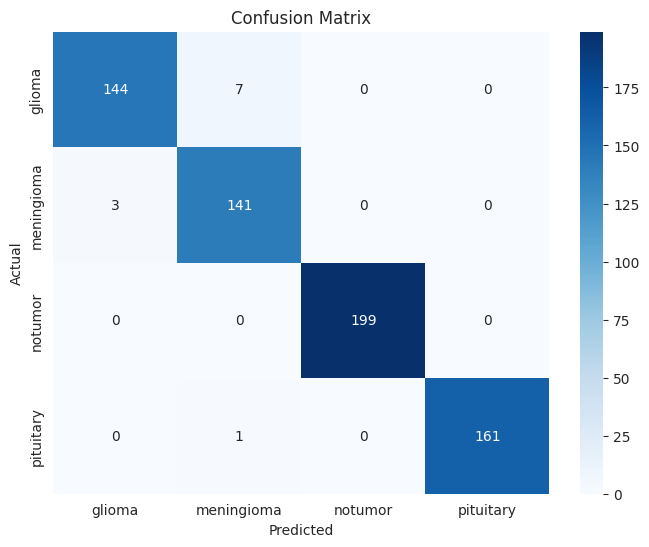

In [ ]:
# ============================
# Confusion Matrix
# ============================

preds_eff = effnet_model.predict(test_gen_eff)
y_pred_eff = np.argmax(preds_eff, axis=1)

cm_eff = confusion_matrix(test_gen_eff.classes, y_pred_eff)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_eff, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



---



*   Accuracy: 0.98, meaning 98 % of the 656 test images were classified correctly.



In [ ]:
print(classification_report(test_gen_eff.classes, y_pred_eff, target_names=classes))

              precision    recall  f1-score   support

      glioma       0.98      0.95      0.97       151
  meningioma       0.95      0.98      0.96       144
     notumor       1.00      1.00      1.00       199
   pituitary       1.00      0.99      1.00       162

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



## Save - Load

In [ ]:
# ============================
# save EfficientNetB0 model
# ============================

model_path = '/content/drive/My Drive/ML/Brain_effnet_Model.h5'
effnet_model.save(model_path)
print(f"Model saved successfully at: {model_path}")

Model saved successfully at: /content/drive/My Drive/ML/Brain_effnet_Model.h5


In [ ]:
# ============================
# load EfficientNetB0 model
# ============================

model_path = '/content/drive/My Drive/ML/Brain_effnet_Model.h5'
effnet_model = load_model(model_path)
print("CNN Model loaded successfully!")

In [ ]:
eff_history = trained_effnet_model.history

import pickle
with open('/content/drive/My Drive/ML/eff_history.pkl', 'wb') as f:
    pickle.dump(eff_history, f)

In [ ]:
import pickle
with open('/content/drive/My Drive/ML/eff_history.pkl', 'rb') as f:
    cnn_history = pickle.load(f)

tr_acc_eff  = eff_history['accuracy']
val_acc_eff = eff_history['val_accuracy']

# **Comparison of Model Accuracy Curves over Epochs**



---

This figure shows how quickly and how well each model learns over 10 epochs:

* EfficientNetB0 achieves high accuracy in just a few epochs, while the CNN may need more epochs to converge.
* EfficientNet’s training and validation curves almost overlap, indicating stronger generalization, whereas the CNN shows a modest divergence (about 3%).

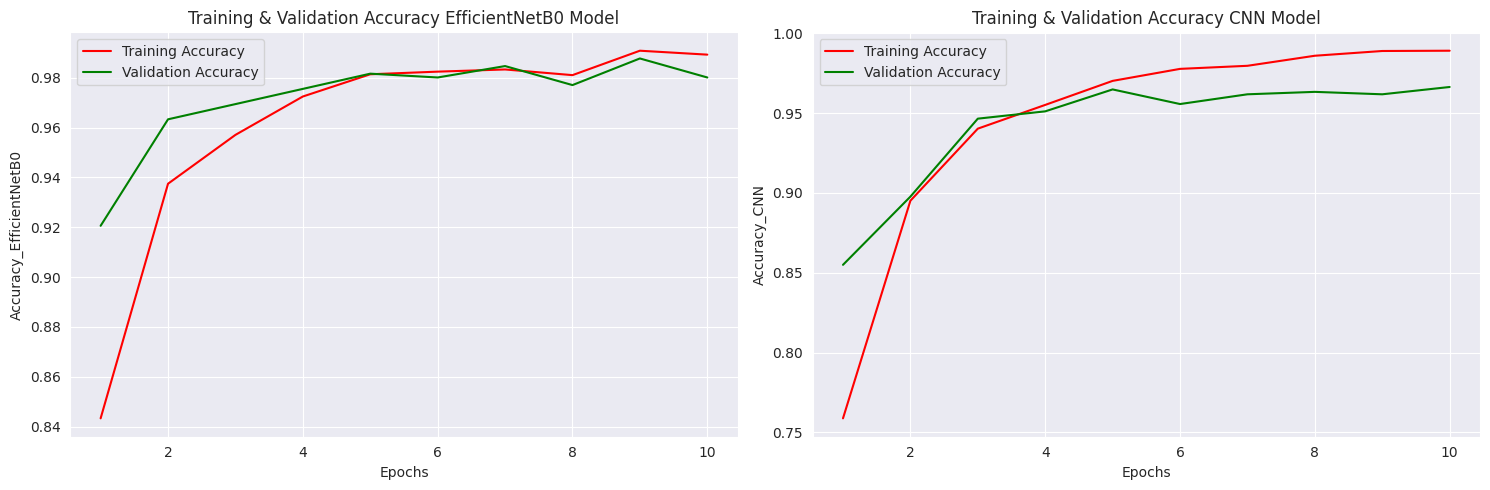

In [ ]:
tr_acc_eff = trained_effnet_model.history['accuracy']
val_acc_eff = trained_effnet_model.history['val_accuracy']

tr_acc_cnn = trained_cnn_model.history['accuracy']
val_acc_cnn = trained_cnn_model.history['val_accuracy']

Epochs_eff = [i+1 for i in range(len(tr_acc_eff))]
Epochs_cnn = [i+1 for i in range(len(tr_acc_cnn))]


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(Epochs_eff, tr_acc_eff, 'r', label='Training Accuracy')
plt.plot(Epochs_eff, val_acc_eff, 'g', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy_EfficientNetB0')
plt.title('Training & Validation Accuracy EfficientNetB0 Model')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_cnn, tr_acc_cnn, 'r', label='Training Accuracy')
plt.plot(Epochs_cnn, val_acc_cnn, 'g', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy_CNN')
plt.title('Training & Validation Accuracy CNN Model')
plt.legend()

plt.tight_layout()
plt.show()

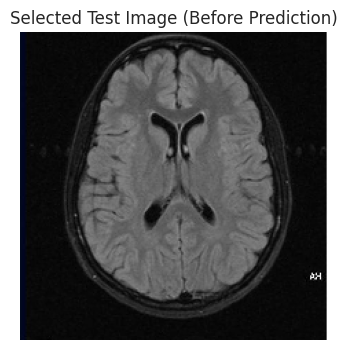

In [ ]:
# Show the original image before making a prediction

sample_img_path = test_df.iloc[0]['filepaths']
img_eff = image.load_img(sample_img_path, target_size=(224, 224))

plt.figure(figsize=(4, 4))
plt.imshow(img_eff)
plt.title("Selected Test Image (Before Prediction)")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


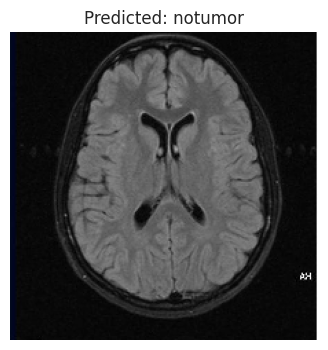

In [ ]:
sample_img_path = test_df.iloc[0]['filepaths']
img_eff = image.load_img(sample_img_path, target_size=(224, 224))
img_array_eff = image.img_to_array(img_eff)
img_array_eff = np.expand_dims(img_array_eff, axis=0)

prediction_eff = effnet_model.predict(img_array_eff)
predicted_class_eff = np.argmax(prediction_eff[0])

eff_class_labels = list(test_gen_eff.class_indices.keys())
predicted_label_eff = eff_class_labels[predicted_class_eff]

plt.figure(figsize=(4, 4))
plt.imshow(img_eff)
plt.title(f"Predicted: {predicted_label_eff}")
plt.axis("off")
plt.show()